# TopicBank Demo

The notebook contains a demonstration of the [TopicBank approach](https://github.com/machine-intelligence-laboratory/OptimalNumberOfTopics/tree/master/topnum/search_methods/topic_bank) for finding an appropriate number of topics.

Dataset used for demonstration is [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), preprocessed in a way described in the notebook [Making-Decorrelation-and-Topic-Selection-Friends.ipynb](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/demos/Making-Decorrelation-and-Topic-Selection-Friends.ipynb).

In [ ]:
# General imports

import numpy as np
import os

from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
# Making `topnum` module visible for Python

import sys

sys.path.insert(0, '..')

In [ ]:
# Optimal number of topics

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.search_methods import TopicBankMethod

## Data

In the folder below must reside the necessary data file in Vowpal Wabbit format.

In [ ]:
DATA_FOLDER_PATH = 'data'

In [ ]:
os.listdir(DATA_FOLDER_PATH)

['_dataset_lthzj9qc',
 '_dataset_ux1_6tj1',
 '_dataset_hvteto6c',
 '_dataset_1fzjutvk',
 '_dataset_0o0fiiqo',
 '_dataset_a00ok3up',
 '_dataset_lh9rv2te',
 '_dataset_0jpn3owo',
 '_dataset_m9qhqs6p',
 '_dataset_5qy6w9hv',
 'twenty_newsgroups__vw__natural_order.txt']

In [ ]:
vw_file_path = os.path.join(
    DATA_FOLDER_PATH,
    'twenty_newsgroups__vw__natural_order.txt'
)

Checking if all OK with data, what modalities does the collection have.

In [ ]:
! head -n 7 $vw_file_path

rec.autos_102994 |@text enlighten bricklin bumper funky
comp.sys.mac.hardware_51861 |@text upgraded oscillator poll detailing attained sink summarizing poll
comp.sys.mac.hardware_51879 |@text ghost sooo sooner picking powerbook dirt powerbook appearence macleak powerbook swing yea solicit subjective breifly hellcat premium willis ecn purdue purdue
sci.space_60880 |@text std std baker suchlike introduce liftoff
talk.politics.guns_54525 |@text rigidly allegedly presenting evidently
sci.med_58080 |@text bouncing probs sean debra sharon accidentally delete
comp.sys.ibm.pc.hardware_60249 |@text controler burst burst burst burst esdi sumex aim txt salesperson burst synchronous


Defining a text collection entity, which is to be passed to topic number search method later:

In [ ]:
text_collection = VowpalWabbitTextCollection(
    vw_file_path,
    main_modality='@text'
)

Let's transform this collection to the TopicNet's Dataset (so as to look at it more easily).

In [ ]:
dataset = text_collection._to_dataset()

In [ ]:
dataset._data.shape

(12778, 2)

In [ ]:
dataset._data.head()

,raw_text,vw_text
id,,
102994,NaN,102994 |@text enlighten bricklin bumper funky
51861,NaN,51861 |@text upgraded oscillator poll detailin...
51879,NaN,51879 |@text ghost sooo sooner picking powerbo...
60880,NaN,60880 |@text std std baker suchlike introduce ...
54525,NaN,54525 |@text rigidly allegedly presenting evid...


The searching method itself.
It has several parameters: some are specific for the renormalization approach, some are common for all the search methods presented in `topnum` module.

In [ ]:
optimizer = TopicBankMethod(
    data = dataset,              # `text_collection` also would be fine here
    min_df_rate=0.001,           # excluding too rare words from text collection's vocabulary
    max_num_models = 100,        # number of models for collecting topics
    one_model_num_topics = 100,  # number of topics in one model
    num_fit_iterations = 100,    # 100 or 200 surely might be enough
    topic_score_threshold_percentile = 90  # 10% of the best model topics according to the score are going to be considered as good
)

Fulfilling the search:

In [ ]:
%%time

optimizer.search_for_optimum(text_collection)


100%|██████████| 100/100 [1:41:59<00:00, 61.20s/it]
CPU times: user 5h 53min 24s, sys: 59min 53s, total: 6h 53min 18s
Wall time: 1h 42min


The search method's result may be accessed as `optimizer._result`.
Let's see what is available here:

In [ ]:
list(optimizer._result.keys())

['optimum',
 'optimum_std',
 'bank_scores',
 'bank_topic_scores',
 'model_scores',
 'model_topic_scores',
 'num_bank_topics',
 'num_model_topics']

Point estimate of the number of topics and standard deviation (std) over the restarts (`num_restarts`):

In [ ]:
result_key_optimum = 'optimum'
result_key_optimum_std = 'optimum_std'

print(
    f'Optimum: {optimizer._result[result_key_optimum]} topics.' +
    f' Std: {optimizer._result[result_key_optimum_std]}'
)

Optimum: 20 topics. Std: 0.0


The number of topics appeared to be $20$!
So, the method worked pretty well for this particular dataset.

In [ ]:
result_key_bank_scores = 'bank_scores'
result_key_bank_topic_scores = 'bank_topic_scores'
result_key_model_scores = 'model_scores'
result_key_model_topic_scores = 'model_topic_scores'

In [ ]:
print(
    'Num iterations:',
    len(optimizer._result[result_key_bank_scores])
)
print(
    '...same as:',
    len(optimizer._result[result_key_model_scores])
)
print(
    '...and:',
    len(optimizer._result[result_key_model_topic_scores])
)
print(
    'Final number of topics:',
    len(optimizer._result[result_key_bank_topic_scores])
)

Num iterations: 100
...same as: 100
...and: 100
Final number of topics: 20


Let us look at the first elements in the result values:

In [ ]:
# Scores for the bank as topic model

list(optimizer._result[result_key_bank_scores])[0]

{'perplexity_score': 21.48740577697754,
 'sparsity_phi_score': nan,
 'sparsity_theta_score': 0.8343402743339539}

In [ ]:
# Averaged scores for bank topics for the particular iteration

list(optimizer._result[result_key_bank_topic_scores])[0]

{'kernel_size': 189,
 'intratext_coherence_score': 0.05932667226131473,
 'top_tokens_coherence_score': None,
 'distance_to_nearest': 0.9975607519680663}

In [ ]:
# Scores for the model trained during the iteration

list(optimizer._result[result_key_model_scores])[0]

{'perplexity_score': 274.0969543457031,
 'sparsity_phi_score': nan,
 'sparsity_theta_score': 0.8591673374176025,
 'intratext_coherence_score': 0.02916695705304543,
 'top_tokens_coherence_score': 0.06221736998880692}

In [ ]:
# Scores for each topic of the current model

list(optimizer._result[result_key_model_topic_scores])[0][:3]

[{'kernel_size': 115,
  'intratext_coherence_score': 0.028208950844903786,
  'top_tokens_coherence_score': None},
 {'kernel_size': 193,
  'intratext_coherence_score': 0.016012161411345004,
  'top_tokens_coherence_score': None},
 {'kernel_size': 85,
  'intratext_coherence_score': 0.022762342045704525,
  'top_tokens_coherence_score': None}]

Using the saved scores one may analyze the process.
For example, how the perplexity changes for the bank during its creation:

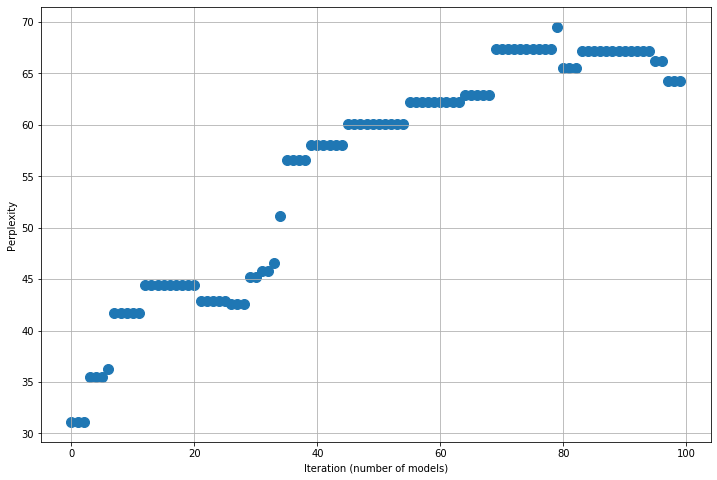

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

x = range(len(list(optimizer._result[result_key_bank_scores])))
y = [s['perplexity_score'] for s in optimizer._result[result_key_bank_scores]]

ax.scatter(x, y, s=100)

ax.set_xlabel('Iteration (number of models)')
ax.set_ylabel('Perplexity')

ax.grid(True)
plt.show()

And the perplexity for ordinary models:

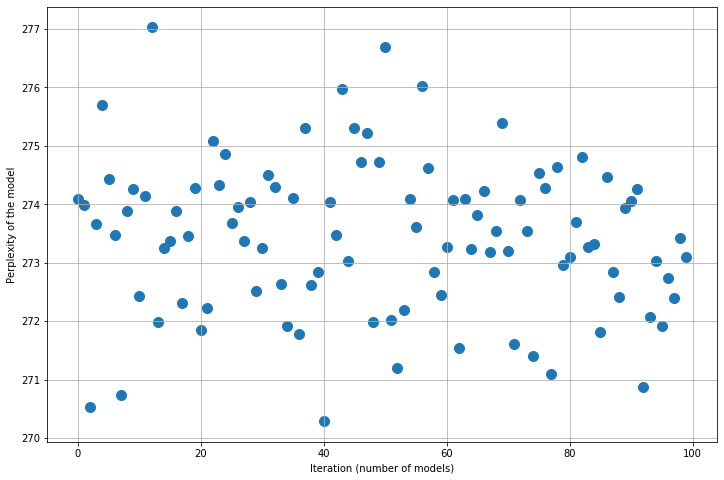

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

x = range(len(list(optimizer._result[result_key_model_scores])))
y = [s['perplexity_score'] for s in optimizer._result[result_key_model_scores]]

ax.scatter(x, y, s=100)

ax.set_xlabel('Iteration (number of models)')
ax.set_ylabel('Perplexity of the model')

ax.grid(True)
plt.show()

And another score worth looking at — topic coherence (for example, intratext), as a measure of topic interpretability:

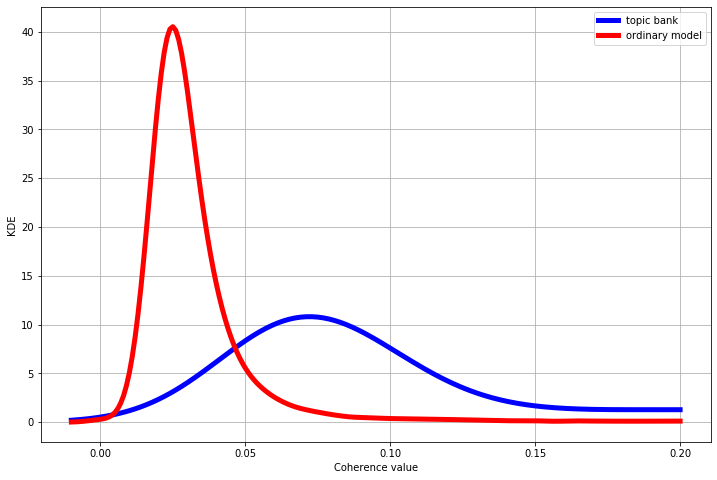

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

score_name = 'intratext_coherence_score'

x = range(len(list(optimizer._result[result_key_bank_topic_scores])))
y_bank = [
    s[score_name]
    for s in optimizer._result[result_key_bank_topic_scores]
]
y_model = [
    s[score_name]
    for model_scores in optimizer._result[result_key_model_topic_scores]
    for s in model_scores
]
y_model = [v if v is not None else 0.0 for v in y_model]

gauss_for_bank = gaussian_kde(y_bank)
gauss_for_models = gaussian_kde(y_model)

x = np.arange(-0.01, 0.2, 0.001)

ax.plot(x, gauss_for_bank(x), color='b', lw=5, label='topic bank')
ax.plot(x, gauss_for_models(x), color='r', lw=5, label='ordinary model')

ax.set_xlabel('Coherence value')
ax.set_ylabel('KDE')
ax.legend()

ax.grid(True)
plt.show()

Distance of newly added topic to the nearest topic already in the bank:

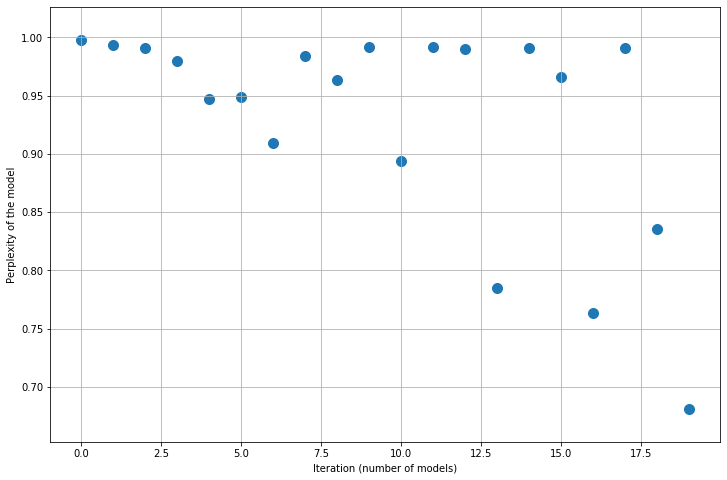

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

x = range(len(list(optimizer._result[result_key_bank_topic_scores])))
y = [s['distance_to_nearest'] for s in optimizer._result[result_key_bank_topic_scores]]

ax.scatter(x, y, s=100)

ax.set_xlabel('Iteration (number of models)')
ax.set_ylabel('Perplexity of the model')

ax.grid(True)
plt.show()

As the bank growths, this distance value shrinks.